In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from surprise import Dataset, SVD
from surprise.prediction_algorithms import KNNBaseline as KNNBasic
from surprise.model_selection import cross_validate
from surprise.reader import Reader
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read csv
ratings = pd.read_csv("../data/movies/ratings_small.csv")
print("Number of records:", ratings.shape)
ratings.head()

Number of records: (100004, 4)


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [3]:
# Reader object for surprise
reader = Reader(rating_scale = (1, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [4]:
# Compute results for PMF (or equivalently SVD)
pmf_results = cross_validate(SVD(), data, measures = ['RMSE', 'MAE'], cv = 5, verbose = False)

# Compute and store mean of test rmse and mae
pmf_test_rmse = pmf_results['test_rmse'].mean()
pmf_test_mae = pmf_results['test_mae'].mean()

# Display results
print("Test RMSE for PMF:", pmf_test_rmse)
print("Test MAE for PMF:", pmf_test_mae)

Test RMSE for PMF: 0.8973522629610866
Test MAE for PMF: 0.6912888771902784


In [5]:
def collaborative_filtering(name, user_based, item_based, min_support, min_k = None, k = None):
    # Initialize the model (user based collaborative filtering (ubcf))
    cf = KNNBasic(sim_options = {'name': name,
                                'user_based': user_based,
                                'item_based': item_based,
                                'min_support': min_support,
                                'min_k': min_k},
                                verbose = False)

    # Compute results for user based collaborative filtering
    cf_results = cross_validate(cf, data, measures = ['RMSE', 'MAE'], cv = 5, verbose = False)

    # Compute and store mean of test rmse and mae
    cf_rmse = cf_results['test_rmse'].mean()
    cf_mae = cf_results['test_mae'].mean()

    return cf_rmse, cf_mae

In [6]:
# User based, cosine
ubc_rmse, ubc_mae = collaborative_filtering(
    name = 'cosine',
    user_based = True,
    item_based = False, 
    min_support = True,
    min_k = 2
)

# User based, msd (mean squared difference)
ubmsd_rmse, ubmsd_mae = collaborative_filtering(
    name = 'msd',
    user_based = True,
    item_based = False, 
    min_support = True,
    min_k = 2
)

# User based, pearson
ubp_rmse, ubp_mae = collaborative_filtering(
    name = 'pearson',
    user_based = True,
    item_based = False, 
    min_support = True,
    min_k = 2
)

# Item based, cosine
ibc_rmse, ibc_mae = collaborative_filtering(
    name = 'cosine',
    user_based = False,
    item_based = True, 
    min_support = True,
    min_k = 2
)

# Item based, MSD (mean squared difference)
ibmsd_rmse, ibmsd_mae = collaborative_filtering(
    name = 'msd',
    user_based = False,
    item_based = True, 
    min_support = True,
    min_k = 2
)

# Item based, pearson
ibp_rmse, ibp_mae = collaborative_filtering(
    name = 'pearson',
    user_based = False,
    item_based = True, 
    min_support = True,
    min_k = 2
)

# Display results
print("Test RMSE for User Based Collaborative Filtering with cosine similarity:", ubc_rmse)
print("Test MAE for User Based Collaborative Filtering with cosine similarity:", ubc_mae)

print()

print("Test RMSE for User Based Collaborative Filtering with MSD similarity:", ubmsd_rmse)
print("Test MAE for User Based Collaborative Filtering with MSD similarity:", ubmsd_mae)

print()

print("Test RMSE for User Based Collaborative Filtering with pearson similarity:", ubp_rmse)
print("Test MAE for User Based Collaborative Filtering with pearson similarity:", ubp_mae)

print()

print("Test RMSE for Item Based Collaborative Filtering with cosine similarity:", ibc_rmse)
print("Test MAE for Item Based Collaborative Filtering with cosine similarity:", ibc_mae)

print()

print("Test RMSE for Item Based Collaborative Filtering with MSD similarity:", ibmsd_rmse)
print("Test MAE for Item Based Collaborative Filtering with MSD similarity:", ibmsd_mae)

print()

print("Test RMSE for Item Based Collaborative Filtering with pearson similarity:", ibp_rmse)
print("Test MAE for Item Based Collaborative Filtering with pearson similarity:", ibp_mae)

Test RMSE for User Based Collaborative Filtering with cosine similarity: 0.9012470535310925
Test MAE for User Based Collaborative Filtering with cosine similarity: 0.6911951807445046

Test RMSE for User Based Collaborative Filtering with MSD similarity: 0.896608310504706
Test MAE for User Based Collaborative Filtering with MSD similarity: 0.6866690960053037

Test RMSE for User Based Collaborative Filtering with pearson similarity: 0.9023912199367674
Test MAE for User Based Collaborative Filtering with pearson similarity: 0.6902402330955566

Test RMSE for Item Based Collaborative Filtering with cosine similarity: 0.9098616291694608
Test MAE for Item Based Collaborative Filtering with cosine similarity: 0.7019208828966695

Test RMSE for Item Based Collaborative Filtering with MSD similarity: 0.8880206596145024
Test MAE for Item Based Collaborative Filtering with MSD similarity: 0.6814631405187498

Test RMSE for Item Based Collaborative Filtering with pearson similarity: 0.900881374210506

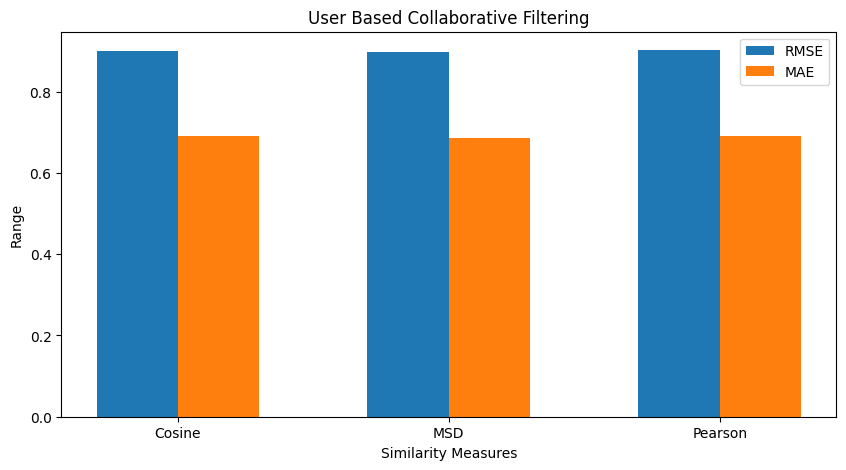

In [7]:
# Plot results
ub_rmse = [ubc_rmse, ubmsd_rmse, ubp_rmse]
ub_mae = [ubc_mae, ubmsd_mae, ubp_mae]

ib_rmse = [ibc_rmse, ibmsd_rmse, ibp_rmse]
ib_mae = [ibc_mae, ibmsd_mae, ibp_mae]

# Position of bars on x-axis
ind = np.arange(3)
width = 0.3

plt.figure(figsize = (10, 5))
plt.bar(ind, ub_rmse, width, label = 'RMSE')
plt.bar(ind+width, ub_mae, width, label = 'MAE')
plt.xlabel("Similarity Measures")
plt.ylabel("Range")
plt.title("User Based Collaborative Filtering")
plt.xticks(ind + width / 2, ('Cosine', 'MSD', 'Pearson'))
plt.legend(loc = 'best')
plt.show()

In [8]:
ub_rmse_k = []
ub_mae_k = []
ib_rmse_k = []
ib_mae_k = []
k_values = []

for k in tqdm(range(2, 15)):
    # Using cosine similarity

    # Compute rmse and mae for user based
    rmse, mae = collaborative_filtering(
        name = 'cosine',
        user_based = True, 
        item_based = False,
        min_support = True,
        k = k,
        min_k = 2
    )

    # Append scores for user based
    ub_rmse_k.append(rmse)
    ub_mae_k.append(mae)

    # Compute rmse and mae for item based
    rmse, mae = collaborative_filtering(
        name = 'cosine',
        user_based = False,
        item_based = True,
        min_support = True,
        k = k,
        min_k = 2
    )

    # Append scores for item based
    ib_rmse_k.append(rmse)
    ib_mae_k.append(mae)

    # Append k value
    k_values.append(k)

100%|██████████| 13/13 [11:53<00:00, 54.88s/it]


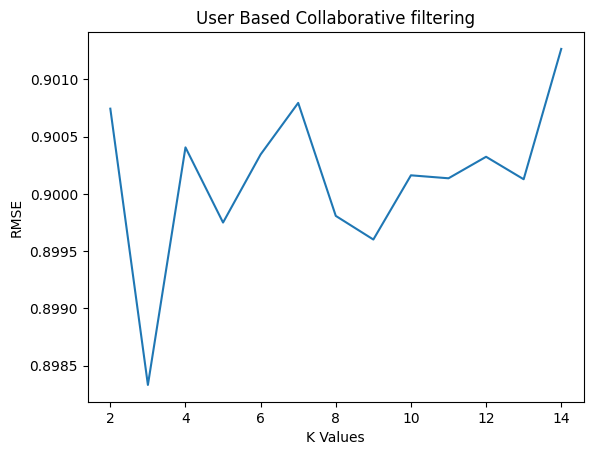

In [9]:
# Plot line graph
sns.lineplot(x = k_values, y = ub_rmse_k)
plt.xlabel("K Values")
plt.ylabel('RMSE')
plt.title("User Based Collaborative filtering")
plt.show()

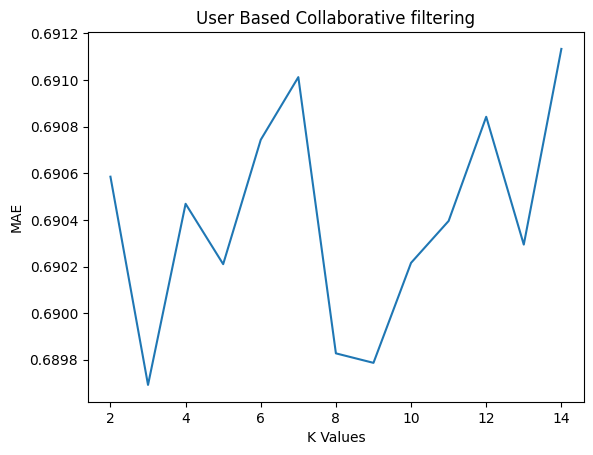

In [10]:
sns.lineplot(x = k_values, y = ub_mae_k)
plt.xlabel("K Values")
plt.ylabel('MAE')
plt.title("User Based Collaborative filtering")
plt.show()

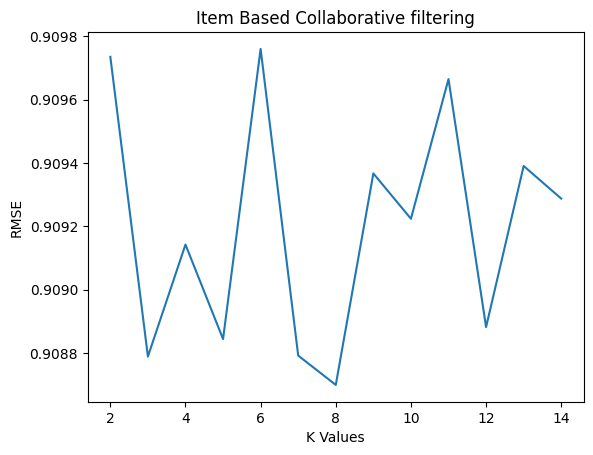

In [11]:
sns.lineplot(x = k_values, y = ib_rmse_k)
plt.xlabel("K Values")
plt.ylabel('RMSE')
plt.title("Item Based Collaborative filtering")
plt.show()

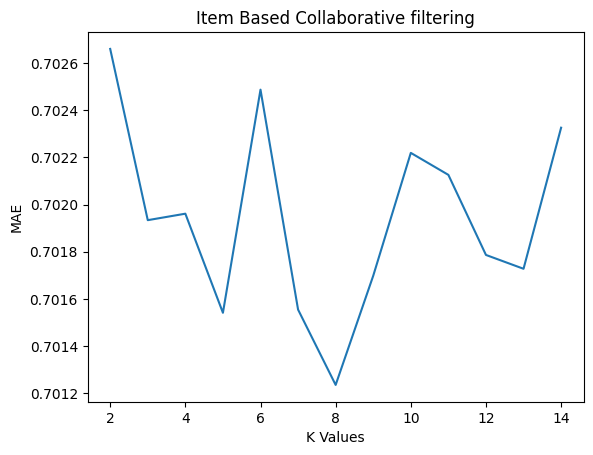

In [12]:
sns.lineplot(x = k_values, y = ib_mae_k)
plt.xlabel("K Values")
plt.ylabel('MAE')
plt.title("Item Based Collaborative filtering")
plt.show()